Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Problem Statement:**

**Using the input features to classify the type of drug.**


Importing Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras import models
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model

import keras

Loading dataset

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/drug200.csv')

df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [ ]:
df.dtypes

Age              int64
Sex             object
BP              object
Cholesterol     object
Na_to_K        float64
Drug            object
dtype: object

In [ ]:
print(f'Minimum age: ' + str(df['Age'].min()))
print(f'Maximum age: ' + str(df['Age'].max()))

Minimum age: 15
Maximum age: 74


Normally distributed Age

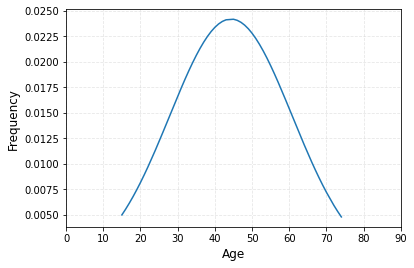

In [ ]:
# Calculating Mean and Standard deviation of Age
df_mean = np.mean(df["Age"])
df_std = np.std(df["Age"])
 
# Calculating probability density function (PDF)
pdf = stats.norm.pdf(df["Age"].sort_values(), df_mean, df_std)

# Drawing a graph
plt.plot(df["Age"].sort_values(), pdf)
plt.xlim([0,90])  
plt.xlabel("Age", size=12)    
plt.ylabel("Frequency", size=12)                
plt.grid(True, alpha=0.3, linestyle="--")
plt.show()

In [ ]:
def uniqueClasses(col):
  print(f'Unique classes in {col}:')
  for i in df[col].unique():
    print(i)
  print('\n')

Unique Classes in categorical data

In [ ]:
uniqueClasses('Sex')
uniqueClasses('BP')
uniqueClasses('Cholesterol')
uniqueClasses('Drug')

Unique classes in Sex:
F
M


Unique classes in BP:
HIGH
LOW
NORMAL


Unique classes in Cholesterol:
HIGH
NORMAL


Unique classes in Drug:
DrugY
drugC
drugX
drugA
drugB




Frequency of each drug

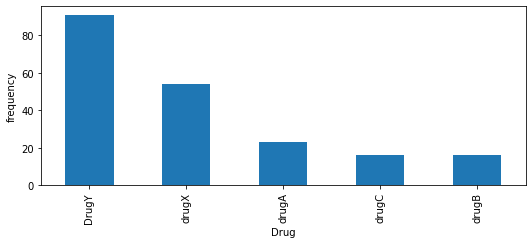

In [ ]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots()

df['Drug'].value_counts().plot(ax=ax, kind='bar', xlabel='Drug', ylabel='frequency')

plt.show()

Using OneHotEncoder to transform nominal categorical data-Sex 



In [ ]:
ohe=OneHotEncoder(sparse=False)

Sex_Columns=ohe.fit_transform(df[['Sex']])
Sex_ColumnNames=ohe.get_feature_names_out(['Sex'])
Sex_final=pd.DataFrame(Sex_Columns, columns=Sex_ColumnNames)

df=pd.concat([df, Sex_final], axis=1, sort=False)
df.head()

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Age,Sex,BP,Cholesterol,Na_to_K,Drug,Sex_F,Sex_M
0,23,F,HIGH,HIGH,25.355,DrugY,1.0,0.0
1,47,M,LOW,HIGH,13.093,drugC,0.0,1.0
2,47,M,LOW,HIGH,10.114,drugC,0.0,1.0
3,28,F,NORMAL,HIGH,7.798,drugX,1.0,0.0
4,61,F,LOW,HIGH,18.043,DrugY,1.0,0.0


Using OridnalEncoder to transform ordinal categorical data 


1.   Cholesterol
2.   BP



In [ ]:
oe_bp=OrdinalEncoder(categories=[['LOW', 'NORMAL', 'HIGH']])
oe_Cholesterol=OrdinalEncoder(categories=[['NORMAL', 'HIGH']])

Cholesterol_Columns=oe_Cholesterol.fit_transform(df[['Cholesterol']])
Cholesterol_final=pd.DataFrame(Cholesterol_Columns, columns=['Cholesterol_updated'])

BP_Columns=oe_bp.fit_transform(df[['BP']])
BP_final=pd.DataFrame(BP_Columns, columns=['BP_updated'])

df=pd.concat([df, Cholesterol_final, BP_final], axis=1, sort=False)
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug,Sex_F,Sex_M,Cholesterol_updated,BP_updated
0,23,F,HIGH,HIGH,25.355,DrugY,1.0,0.0,1.0,2.0
1,47,M,LOW,HIGH,13.093,drugC,0.0,1.0,1.0,0.0
2,47,M,LOW,HIGH,10.114,drugC,0.0,1.0,1.0,0.0
3,28,F,NORMAL,HIGH,7.798,drugX,1.0,0.0,1.0,1.0
4,61,F,LOW,HIGH,18.043,DrugY,1.0,0.0,1.0,0.0



Encoding the drugs as the output

In [ ]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df[['Drug']])
y

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 3, 3, 4, 0, 4, 0, 3, 0, 0, 3, 0, 0, 0, 4, 0, 4, 1, 3, 0, 0, 0,
       0, 0, 0, 0, 0, 4, 0, 0, 4, 2, 4, 0, 4, 4, 1, 4, 4, 4, 0, 2, 0, 4,
       4, 4, 1, 3, 0, 0, 0, 4, 0, 0, 2, 3, 2, 0, 4, 0, 0, 1, 0, 4, 2, 0,
       1, 4, 0, 0, 2, 0, 4, 0, 0, 0, 1, 0, 1, 4, 2, 4, 3, 1, 3, 2, 4, 0,
       0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 1, 1, 3, 4, 0, 4, 4, 0, 2, 0,
       1, 4, 4, 4, 4, 0, 4, 4, 1, 0, 0, 0, 0, 0, 2, 0, 0, 4, 0, 4, 0, 0,
       4, 0, 0, 4, 2, 1, 2, 4, 1, 0, 2, 0, 1, 4, 4, 1, 4, 3, 1, 2, 4, 4,
       0, 3, 1, 0, 3, 4, 4, 2, 4, 0, 0, 0, 0, 4, 0, 1, 4, 4, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 4, 4, 0, 0, 0, 2, 1, 0, 0, 0, 1, 0, 3, 0, 3, 3, 4,
       4, 4])

Creating a train-test split (80:20)

In [ ]:
X=df.drop(df.select_dtypes(include=[object]).columns, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=None, test_size=0.2, shuffle=True)
X

,Age,Na_to_K,Sex_F,Sex_M,Cholesterol_updated,BP_updated
0,23,25.355,1.0,0.0,1.0,2.0
1,47,13.093,0.0,1.0,1.0,0.0
2,47,10.114,0.0,1.0,1.0,0.0
3,28,7.798,1.0,0.0,1.0,1.0
4,61,18.043,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...
195,56,11.567,1.0,0.0,1.0,0.0
196,16,12.006,0.0,1.0,1.0,0.0
197,52,9.894,0.0,1.0,1.0,1.0
198,23,14.020,0.0,1.0,0.0,1.0


**Multiclass Classifiers**

Accuracy Scores

Confusion Matrix

F1 Score

1) Logistic Regression

In [ ]:
LR=LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr', max_iter = 2000).fit(X_train, y_train)
predictions_LR=LR.predict(X_test)
train_predictions_LR=LR.predict(X_train)
score_LR=accuracy_score(y_test, predictions_LR)
train_score_LR=accuracy_score(y_train, train_predictions_LR)
f1_score_LR = f1_score(y_test, predictions_LR, average="weighted")
cm_LR=confusion_matrix(y_test, predictions_LR)
prob_pred_LR=LR.predict_proba(X_test)
auc_LR=roc_auc_score(y_test, prob_pred_LR, multi_class='ovo', average='weighted')

In [ ]:
print(f"Train accuracy: {train_score_LR}")
print(f"Test accuracy: {score_LR}")
print(f"Test F1-score: {f1_score_LR}")

Train accuracy: 0.95
Test accuracy: 0.825
Test F1-score: 0.8106902356902358


Text(142.3, 0.5, 'Actual label')

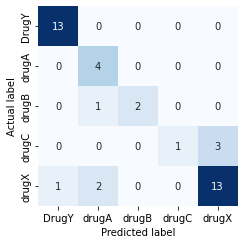

In [ ]:
labels = ['DrugY', 'drugA', 'drugB', 'drugC', 'drugX']
 
sns.heatmap(cm_LR, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')

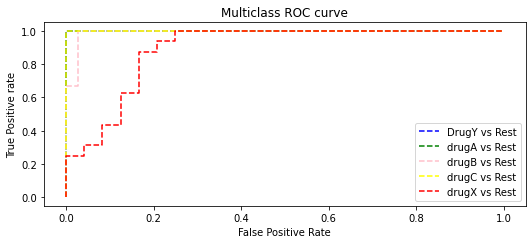

In [ ]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prob_pred_LR[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='blue', label='DrugY vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='drugA vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='pink', label='drugB vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='drugC vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='red', label='drugX vs Rest')
plt.title('Multiclass ROC curve for Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);  

In [ ]:
print(f"Weighted AUC: {auc_LR}")

Weighted AUC: 0.9582031249999999


2) Decision Tree

In [ ]:
DT=DecisionTreeClassifier(max_depth=7).fit(X_train, y_train)
predictions_DT=DT.predict(X_test)
train_predictions_DT=DT.predict(X_train)
score_DT=accuracy_score(y_test, predictions_DT)
train_score_DT=accuracy_score(y_train, train_predictions_DT)
f1_score_DT = f1_score(y_test, predictions_DT, average="weighted")
cm_DT=confusion_matrix(y_test, predictions_DT)
prob_pred_DT=DT.predict_proba(X_test)
auc_DT=roc_auc_score(y_test, prob_pred_DT, multi_class='ovo', average='weighted')

In [ ]:
print(f"Train accuracy: {train_score_DT}")
print(f"Test accuracy: {score_DT}")
print(f"Test F1-score: {f1_score_DT}")

Train accuracy: 1.0
Test accuracy: 1.0
Test F1-score: 1.0


Text(142.3, 0.5, 'Actual label')

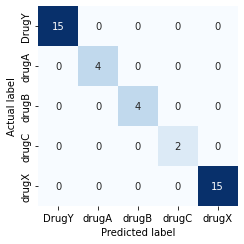

In [ ]:
labels = ['DrugY', 'drugA', 'drugB', 'drugC', 'drugX']
 
sns.heatmap(cm_DT, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')

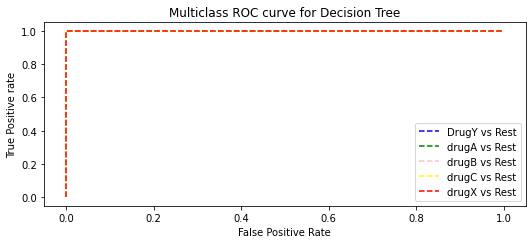

In [ ]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prob_pred_DT[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='blue', label='DrugY vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='drugA vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='pink', label='drugB vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='drugC vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='red', label='drugX vs Rest')
plt.title('Multiclass ROC curve for Decision Tree')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);  

In [ ]:
print(f"Weighted AUC: {auc_DT}")

Weighted AUC: 1.0


In [ ]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 5)
y_test = to_categorical(y_test, 5)
y_train.shape

(160, 5)

3) Artificial Neural Network

In [ ]:
model = models.Sequential()
model.add(layers.Dense(1024, activation='relu', input_shape=(6,)))
model.add(layers.Dense(5, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
checkpoint_filepath = '{epoch:02d}.h5'
checkpoint_dir = os.path.dirname(checkpoint_filepath)

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True)

cb = [model_checkpoint_callback]



In [ ]:
hist1 = model.fit(X_train,
                    y_train,
                    epochs=150,
                    validation_data=(X_test, y_test),
                  callbacks=cb)

Epoch 1/150
1/5 [=====>........................] - ETA: 2s - loss: 0.9305 - accuracy: 0.5625
Epoch 1: val_accuracy improved from -inf to 0.40000, saving model to 01.h5
5/5 [==============================] - 1s 59ms/step - loss: 1.1175 - accuracy: 0.5625 - val_loss: 1.7264 - val_accuracy: 0.4000
Epoch 2/150
1/5 [=====>........................] - ETA: 0s - loss: 1.3826 - accuracy: 0.5000
Epoch 2: val_accuracy improved from 0.40000 to 0.60000, saving model to 02.h5
5/5 [==============================] - 0s 18ms/step - loss: 1.1716 - accuracy: 0.5312 - val_loss: 1.0227 - val_accuracy: 0.6000
Epoch 3/150
1/5 [=====>........................] - ETA: 0s - loss: 0.7947 - accuracy: 0.6250
Epoch 3: val_accuracy did not improve from 0.60000
5/5 [==============================] - 0s 15ms/step - loss: 0.9575 - accuracy: 0.5625 - val_loss: 1.1558 - val_accuracy: 0.4750
Epoch 4/150
1/5 [=====>........................] - ETA: 0s - loss: 1.0081 - accuracy: 0.5938
Epoch 4: val_accuracy did not improve fr

In [ ]:
model.load_weights('149.h5')

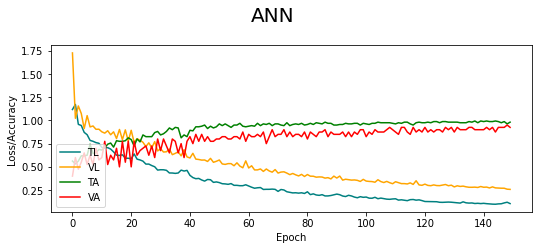

In [ ]:
fig = plt.figure()
plt.plot(hist1.history['loss'], color='teal', label='TL')
plt.plot(hist1.history['val_loss'], color='orange', label='VL')
plt.plot(hist1.history['accuracy'], color='green', label='TA')
plt.plot(hist1.history['val_accuracy'], color='red', label='VA')
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
fig.suptitle('ANN', fontsize=20)
plt.legend(loc="lower left")
plt.show()